In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from shapely import Point
import geopandas

point_of_interest = Point(-90.47416614755436, 47.738145812431185)  # EPSG:4326
input_gdf: geopandas.GeoDataFrame = geopandas.GeoDataFrame(
    geometry=[point_of_interest], crs="EPSG:4326"
)
# Disable scroll wheel zoom so that the map doesn't zoom while scrolling through the notebook
input_gdf.explore(map_kwds={"scrollWheelZoom": False})

In [3]:
# This works, but it is a mess. Use a geopackage instead

# from pathlib import Path
# import geopandas

# aoi_file = Path("../data/raw/test_point.geojson").resolve()
# tile_index_file = Path("../data/interim/tile_index.parquet").resolve()

# aoi = geopandas.read_file(aoi_file)

# tile_index: geopandas.GeoDataFrame = geopandas.read_parquet(tile_index_file)

# aoi_proj: geopandas.GeoDataFrame = aoi.to_crs(tile_index.crs)

# i = tile_index.sindex.query(aoi_proj.geometry).item(1, 0)
# tile_index.iloc[i]

In [4]:
from pathlib import Path
from src.data.point_cloud.pipeline import select_tiles

aoi_file = Path("../data/raw/test_point.geojson").resolve()
tile_index_gpkg = Path("../data/interim/tile_index.gpkg").resolve()
selected_tiles = select_tiles(aoi_file, tile_index_gpkg)
selected_tiles

,name,workunit,ept_json_url,ept_epsg_code,geometry
0,15TXN689291,MN_RainyLake_1_2020,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,3857,"POLYGON ((690000.000 5291000.000, 689000.000 5..."


In [58]:
selected_tiles.at[0, "geometry"].wkt

'POLYGON ((689999.9999999998 5291000, 689000 5291000, 689000 5292000, 689999.9999999998 5292000, 689999.9999999998 5291000))'

In [60]:
selected_tiles.to_crs(3857).at[0, "geometry"].wkt

'POLYGON ((-10070556.392549744 6064431.70400869, -10072039.936622955 6064480.331243674, -10071991.572807558 6065968.535177576, -10070507.773764843 6065919.884312255, -10070556.392549744 6064431.70400869))'

In [5]:
from src.data.point_cloud.point_source import fetch_ept_data

ept_data = fetch_ept_data(selected_tiles.at[0, "workunit"])
ept_data

EPTData(workunit='MN_RainyLake_1_2020', crs=<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, ept_json_url='https://s3-us-west-2.amazonaws.com/usgs-lidar-public/MN_RainyLake_1_2020/ept.json')

In [6]:
ept_data.crs.to_epsg()

3857

In [7]:
from pathlib import Path
from src.data.point_cloud.pipeline import (
    _calc_raster_height,
    _calc_raster_origin_x,
    _calc_raster_origin_y,
    _calc_raster_width,
    _calc_ept_filter_as_wkt,
)

# ept_json_url = "https://fake.com/ept.json"
# ept_filter_as_wkt = "POLYGON ((0 0, 0 10, 10 10, 10 0, 0 0))"
point_source_tag = "vendor_classified_ground_points"
resolution = 0.5
output_dir = Path("../data/processed/").resolve()

enriched_tiles = selected_tiles.assign(
    ept_json_url=ept_data.ept_json_url,
    ept_filter_as_wkt=_calc_ept_filter_as_wkt(
        selected_tiles.buffer(10, join_style="mitre"), ept_data.crs
    ),
    to_epsg=selected_tiles.crs.to_epsg(),
    point_source_tag=point_source_tag,
    resolution=resolution,
    width=_calc_raster_width(selected_tiles.geometry, resolution),
    height=_calc_raster_height(selected_tiles.geometry, resolution),
    origin_x=_calc_raster_origin_x(selected_tiles.geometry),
    origin_y=_calc_raster_origin_y(selected_tiles.geometry),
    output_dir=output_dir,
)

enriched_tiles

,name,workunit,ept_json_url,ept_epsg_code,geometry,ept_filter_as_wkt,to_epsg,point_source_tag,resolution,width,height,origin_x,origin_y,output_dir
0,15TXN689291,MN_RainyLake_1_2020,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,3857,"POLYGON ((690000.000 5291000.000, 689000.000 5...","POLYGON ((-10070542.043322 6064416.335928, -10...",6344,vendor_classified_ground_points,0.5,2000,2000,689000.0,5291000.0,/home/dpower/projects/geospatial/culvert-visio...


In [8]:
from src.data.point_cloud.point_source import vendor_classified_ground_points
from geopandas import GeoDataFrame
from pandas import Series


def get_vendor_classified_ground_point_stages(enriched_tiles: GeoDataFrame) -> Series:
    return enriched_tiles.apply(
        lambda gdf: vendor_classified_ground_points(
            gdf.ept_json_url,
            gdf.ept_filter_as_wkt,
            gdf.to_epsg,
            gdf.point_source_tag,
        ),
        axis=1,
    )

In [9]:
from src.data.point_cloud.product import delauney_mesh_dem

product_stages = enriched_tiles.assign(
    product_stages=enriched_tiles.apply(
        lambda gdf: delauney_mesh_dem(
            gdf.point_source_tag,
            gdf.resolution,
            gdf.width,
            gdf.height,
            gdf.origin_x,
            gdf.origin_y,
            gdf.output_dir,
            gdf.name,
        ),
        axis=1,
    )
)
product_stages

,name,workunit,ept_json_url,ept_epsg_code,geometry,ept_filter_as_wkt,to_epsg,point_source_tag,resolution,width,height,origin_x,origin_y,output_dir,product_stages
0,15TXN689291,MN_RainyLake_1_2020,https://s3-us-west-2.amazonaws.com/usgs-lidar-...,3857,"POLYGON ((690000.000 5291000.000, 689000.000 5...","POLYGON ((-10070542.043322 6064416.335928, -10...",6344,vendor_classified_ground_points,0.5,2000,2000,689000.0,5291000.0,/home/dpower/projects/geospatial/culvert-visio...,"[{'tag': 'delaunay_mesh', 'inputs': ['vendor_c..."


In [10]:
from src.data.point_cloud.product import delauney_mesh_dem
from geopandas import GeoDataFrame
from pandas import Series


def get_delauney_mesh_dem_stages(enriched_tiles: GeoDataFrame) -> Series:
    return enriched_tiles.apply(
        lambda gdf: delauney_mesh_dem(
            gdf.point_source_tag,
            gdf.resolution,
            gdf.width,
            gdf.height,
            gdf.origin_x,
            gdf.origin_y,
            gdf.output_dir,
            gdf["name"],
        ),
        axis=1,
    )

In [11]:
enriched_tiles.apply(lambda gdf: gdf["name"], axis=1)

0    15TXN689291
dtype: object

In [12]:
stages = enriched_tiles.filter(["name", "geometry"], axis="columns").assign(
    point_source_stages=get_vendor_classified_ground_point_stages(enriched_tiles),
    product_stages=get_delauney_mesh_dem_stages(enriched_tiles),
)
stages

,name,geometry,point_source_stages,product_stages
0,15TXN689291,"POLYGON ((690000.000 5291000.000, 689000.000 5...","[{'tag': 'raw_points', 'type': 'readers.ept', ...","[{'tag': 'delaunay_mesh', 'inputs': ['vendor_c..."


In [13]:
pipeline_stages = enriched_tiles.filter(["name", "geometry"], axis="columns").assign(
    pipeline_stages=get_vendor_classified_ground_point_stages(enriched_tiles)
    + get_delauney_mesh_dem_stages(enriched_tiles)
)
pipeline_stages

,name,geometry,pipeline_stages
0,15TXN689291,"POLYGON ((690000.000 5291000.000, 689000.000 5...","[{'tag': 'raw_points', 'type': 'readers.ept', ..."


In [25]:
pipeline_stages.at[0, "pipeline_stages"]

[{'tag': 'raw_points',
  'type': 'readers.ept',
  'filename': 'https://s3-us-west-2.amazonaws.com/usgs-lidar-public/MN_RainyLake_1_2020/ept.json',
  'polygon': 'POLYGON ((-10070542.043322 6064416.335928, -10072055.255677 6064465.935467, -10072005.927186 6065983.90372, -10070492.449561 6065934.279596, -10070542.043322 6064416.335928))'},
 {'tag': 'ground_only',
  'inputs': ['raw_points'],
  'type': 'filters.range',
  'limits': 'Classification[2:2]'},
 {'tag': 'vendor_classified_ground_points',
  'inputs': ['ground_only'],
  'type': 'filters.reprojection',
  'out_srs': 'EPSG:6344'},
 {'tag': 'delaunay_mesh',
  'inputs': ['vendor_classified_ground_points'],
  'type': 'filters.delaunay'},
 {'tag': 'faceraster',
  'inputs': ['delaunay_mesh'],
  'type': 'filters.faceraster',
  'resolution': 0.5,
  'width': 2000,
  'height': 2000,
  'origin_x': 689000.0,
  'origin_y': 5291000.0},
 {'tag': 'write_raster',
  'inputs': ['faceraster'],
  'type': 'writers.raster',
  'filename': '/home/dpower/proje

In [15]:
import json
import pdal

pipeline_json = json.dumps(pipeline_stages.at[0, "pipeline_stages"])

pipeline = pdal.Pipeline(pipeline_json)
pipeline.execute()

13010756

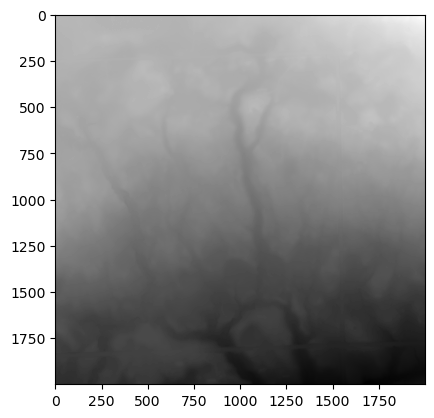

<Axes: >

In [55]:
import rasterio
from rasterio.plot import show

geotiff = pipeline_stages.at[0, "pipeline_stages"][-1]["filename"]

with rasterio.open(geotiff) as f:
    dem = f.read()
    meta = f.meta

show(dem, cmap="gray")

In [56]:
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -999999.0,
 'width': 2000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(6344),
 'transform': Affine(0.5, 0.0, 689000.0,
        0.0, -0.5, 5292000.0)}